In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, make_scorer

import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [18]:
train_data = pd.read_csv("train.csv")
print(train_data.shape)
train_data.head()

(42307, 21)


,Unnamed: 0,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,...,Sector,ApprovalDate,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural
0,0,163,21,1.0,0,0,1,N,N,31-Jan-98,...,0,22-Sep-06,2006,PHOENIX,AZ,SD,"$80,000.00","$80,000.00","$68,000.00",0
1,1,84,6,1.0,4,0,0,0,N,31-Oct-93,...,62,30-Jun-92,1992,MCALESTER,OK,OK,"$287,000.00","$287,000.00","$229,600.00",0
2,2,242,45,1.0,4,90,0,N,N,31-Aug-01,...,42,18-Apr-01,2001,HAWTHORNE,NJ,NJ,"$31,983.00","$30,000.00","$15,000.00",1
3,3,237,4,1.0,0,0,0,N,N,31-Aug-07,...,33,6-Oct-03,2004,NASHVILLE,TN,SD,"$229,000.00","$229,000.00","$229,000.00",0
4,4,184,0,1.0,0,0,0,N,N,8-Jun-83,...,0,17-Dec-99,2000,POMONA,CA,CA,"$525,000.00","$525,000.00","$393,750.00",0


In [19]:
X = train_data.drop(["Unnamed: 0", "MIS_Status"], axis=1)
y = train_data["MIS_Status"]

for col in X.columns:
    if X[col].dtype == "object":
        X[col] = X[col].astype("category")

In [20]:
def s1_score(y_true, y_pred):
    # 混同行列の取得
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # s1-scoreの計算
    sensitivity = tp / (tp + fn)  # Recall
    precision = tp / (tp + fp)    # Precision

    s1 = 2 * (sensitivity * precision) / (sensitivity + precision) if (sensitivity + precision) > 0 else 0

    return s1

In [21]:
def baseline(X, y, params, cv, s1_scorer):
    
    for i, (train_index, test_index) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # LightGBMモデルの学習
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train)

        # テストデータで予測
        y_pred = model.predict(X_test)

        # s1-scoreの計算
        s1 = s1_score(y_test, y_pred)
        print(f"Fold {i+1} - s1-score: {s1:.4f}")

        # 特徴量の重要度を取得
        feature_importance = model.feature_importances_

        # 特徴量の名前を取得
        feature_names = X.columns

        # 重要度をデータフレームに格納
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

        # 重要度で降順にソート
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

        # バー プロットで可視化
        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
        plt.xlabel('Feature Importance')
        plt.title(f'Feature Importance Plot - Fold {i+1}')
        plt.show()
        
    return y_pred, feature_importance_df

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 30213, number of negative: 3632
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8265
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892687 -> initscore=2.118489
[LightGBM] [Info] Start training from score 2.118489
Fold 1 - s1-score: 0.9479


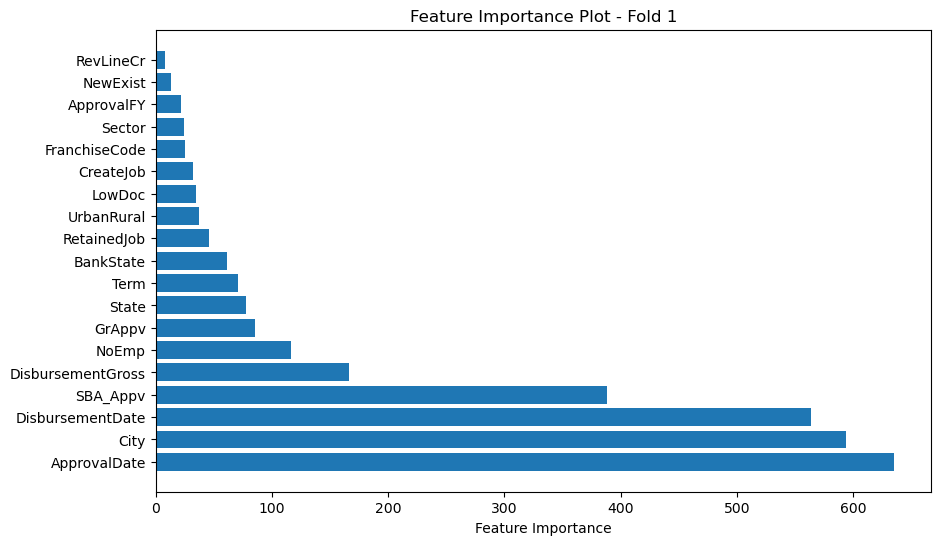

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 30213, number of negative: 3632
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8269
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892687 -> initscore=2.118489
[LightGBM] [Info] Start training from score 2.118489
Fold 2 - s1-score: 0.9465


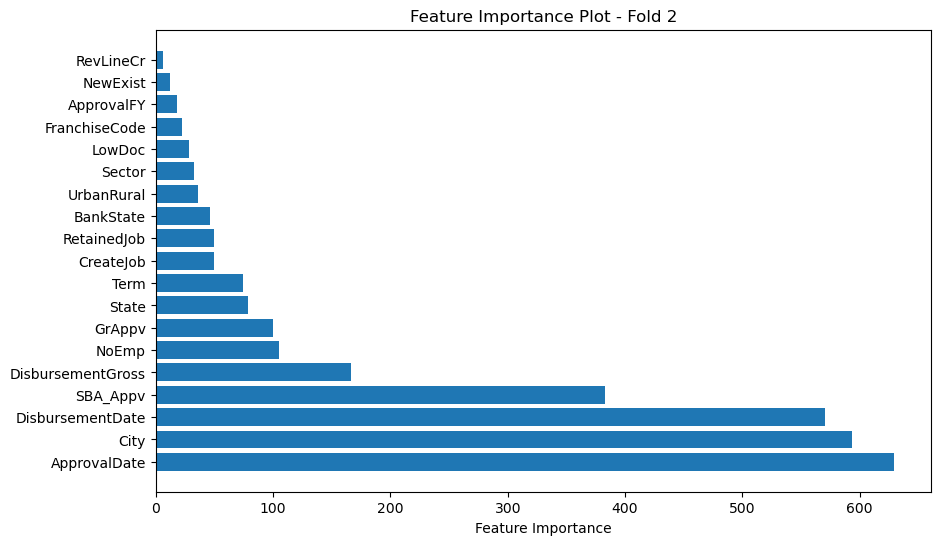

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 30214, number of negative: 3632
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8244
[LightGBM] [Info] Number of data points in the train set: 33846, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892690 -> initscore=2.118522
[LightGBM] [Info] Start training from score 2.118522
Fold 3 - s1-score: 0.9460


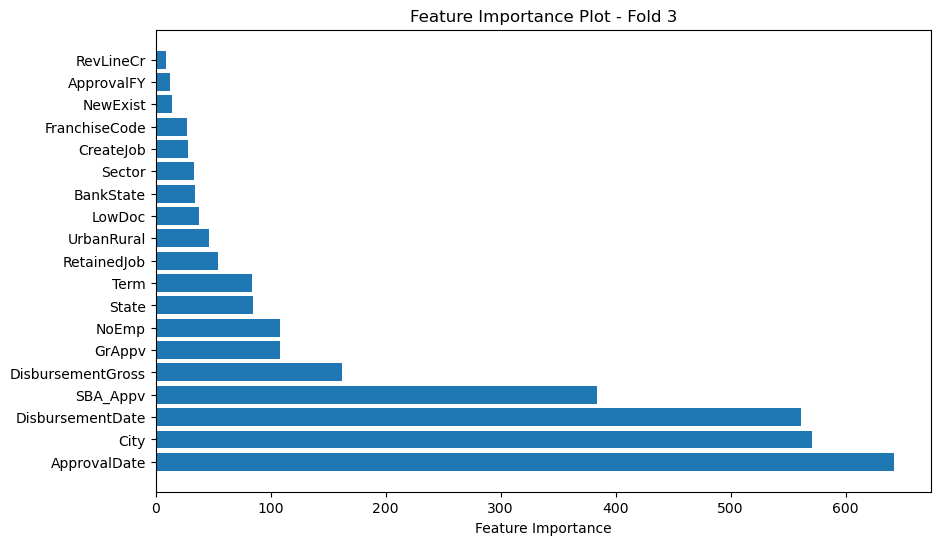

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 30214, number of negative: 3632
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8251
[LightGBM] [Info] Number of data points in the train set: 33846, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892690 -> initscore=2.118522
[LightGBM] [Info] Start training from score 2.118522
Fold 4 - s1-score: 0.9464


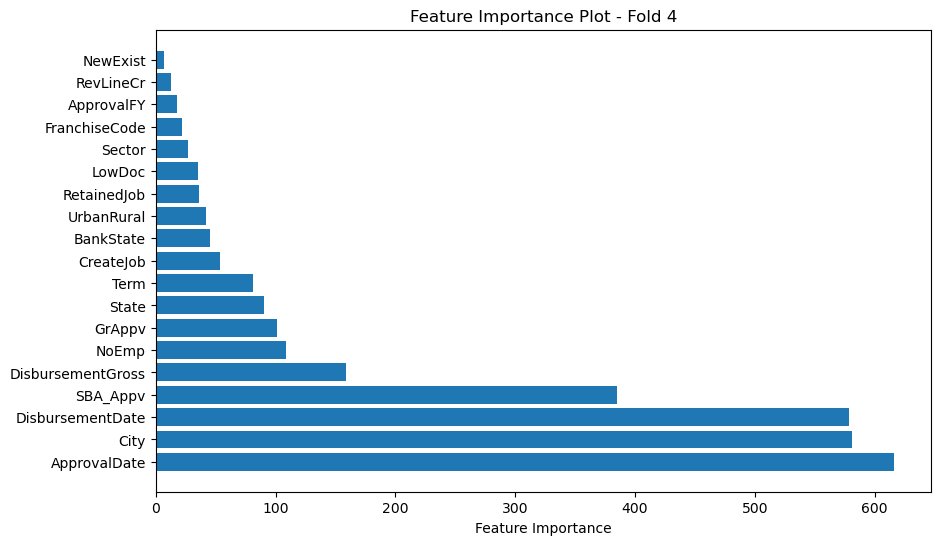

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 30214, number of negative: 3632
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8302
[LightGBM] [Info] Number of data points in the train set: 33846, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892690 -> initscore=2.118522
[LightGBM] [Info] Start training from score 2.118522
Fold 5 - s1-score: 0.9453


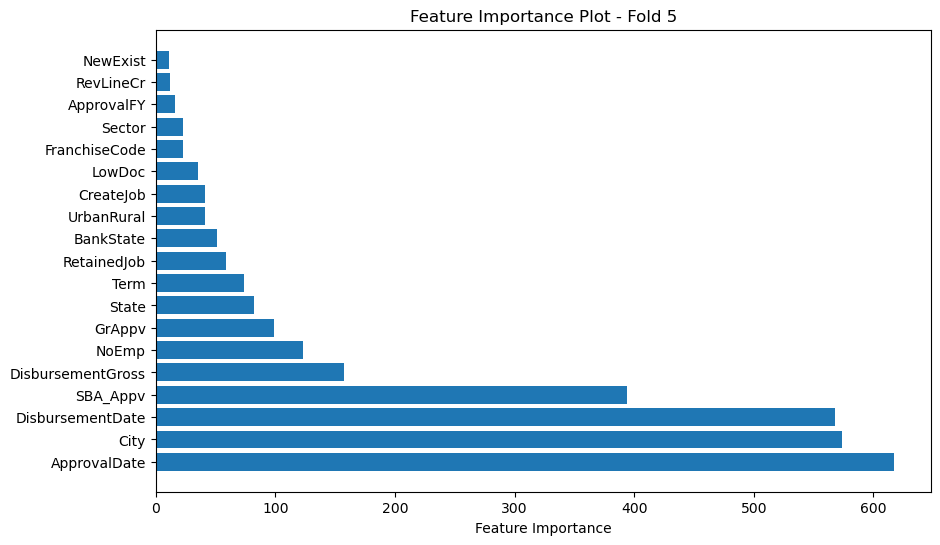

In [23]:
s1_scorer = make_scorer(s1_score, greater_is_better=True)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
}

y_pred, feature_importance_df = baseline(X, y, params, cv, s1_scorer)

In [24]:
feature_importance_df

,Feature,Importance
10,ApprovalDate,617
12,City,574
8,DisbursementDate,568
17,SBA_Appv,394
15,DisbursementGross,157
1,NoEmp,123
16,GrAppv,99
13,State,82
0,Term,74
4,RetainedJob,59


In [ ]:
test_data = pd.read_csv("test.csv")
test_data.head()

,Unnamed: 0,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,Sector,ApprovalDate,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural
0,42307,5,2,1.0,1,0,0,T,N,31-Jul-04,23,6-Aug-07,2007,SUNNYVALE,CA,CA,"$25,000.00","$25,000.00","$21,250.00",1
1,42308,235,13,1.0,9,14,77725,Y,N,11-Jan-95,44,8-Mar-04,2004,PITTSBURGH,PA,PA,"$15,000.00","$15,000.00","$7,500.00",0
2,42309,31,5,2.0,0,0,0,N,NaN,NaN,56,27-Feb-07,2007,LITTLE ROCK,AR,AR,"$28,000.00","$28,000.00","$23,800.00",1
3,42310,120,4,1.0,0,1,0,Y,N,30-Apr-99,62,19-Dec-97,1998,LITTLE ROCK,AR,AR,"$7,500.00","$7,500.00","$6,375.00",2
4,42311,63,13,1.0,0,8,1,N,N,31-Dec-05,42,10-Jul-09,2009,Louisville,KY,DE,"$91,000.00","$93,000.00","$93,000.00",0


In [59]:
def test_prediction(test_data):
    X_test = test_data.copy()
    X_test = test_data.drop("Unnamed: 0", axis=1)
    for col in X_test.columns:
        if X_test[col].dtype == "object":
            X_test[col] = X_test[col].astype("category")
    
    model = lgb.LGBMClassifier(**params)
    model.fit(X, y)
    predictions = model.predict(X_test)
    sample_submit = pd.read_csv('sample_submission.csv', index_col=0, header=None)
    sample_submit[1] = predictions
    # display(sample_submit)
    sample_submit.to_csv('submit_to_baseline.csv', header=None)

In [62]:
test_prediction(test_data)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 37767, number of negative: 4540
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9226
[LightGBM] [Info] Number of data points in the train set: 42307, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892689 -> initscore=2.118509
[LightGBM] [Info] Start training from score 2.118509


(42307, 21)
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 30213, number of negative: 3632
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8265
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892687 -> initscore=2.118489
[LightGBM] [Info] Start training from score 2.118489
Fold 1 - s1-score: 0.9479


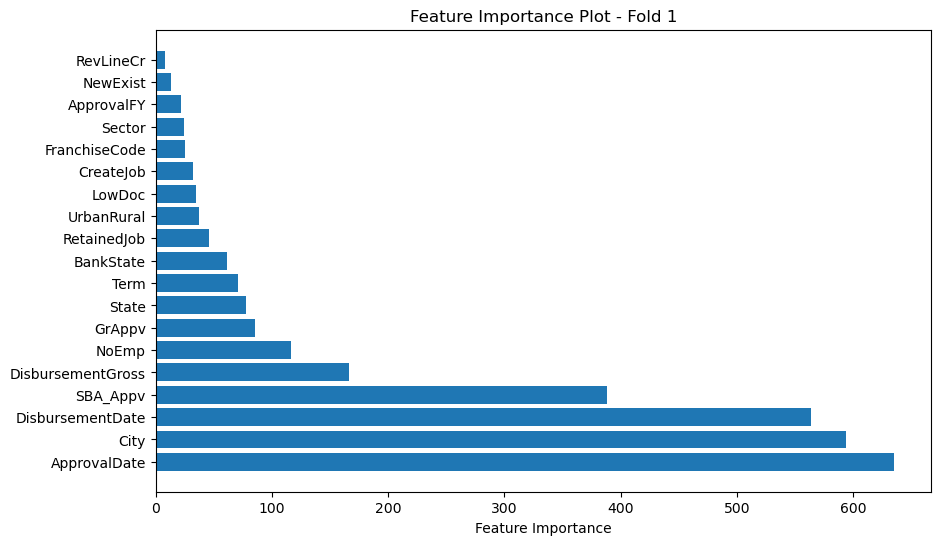

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 30213, number of negative: 3632
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8269
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892687 -> initscore=2.118489
[LightGBM] [Info] Start training from score 2.118489
Fold 2 - s1-score: 0.9465


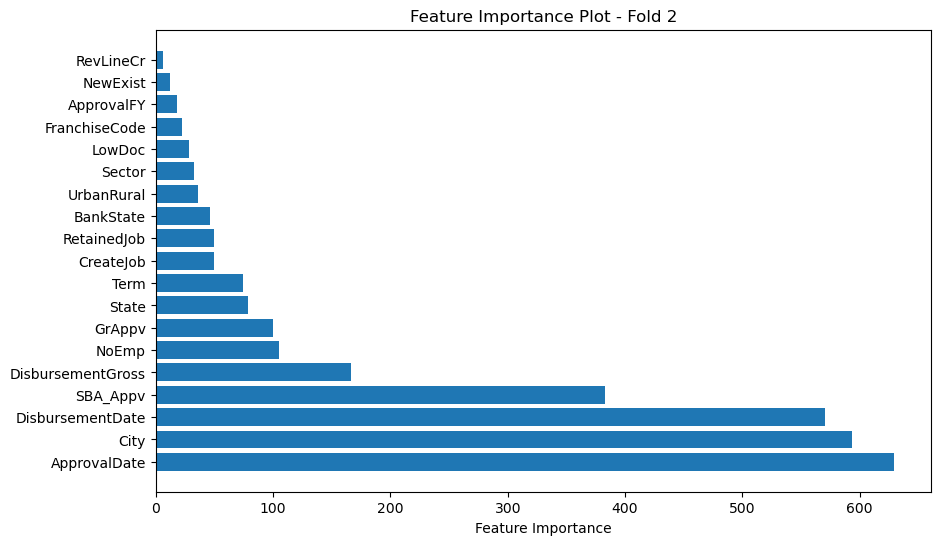

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 30214, number of negative: 3632
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8244
[LightGBM] [Info] Number of data points in the train set: 33846, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892690 -> initscore=2.118522
[LightGBM] [Info] Start training from score 2.118522
Fold 3 - s1-score: 0.9460


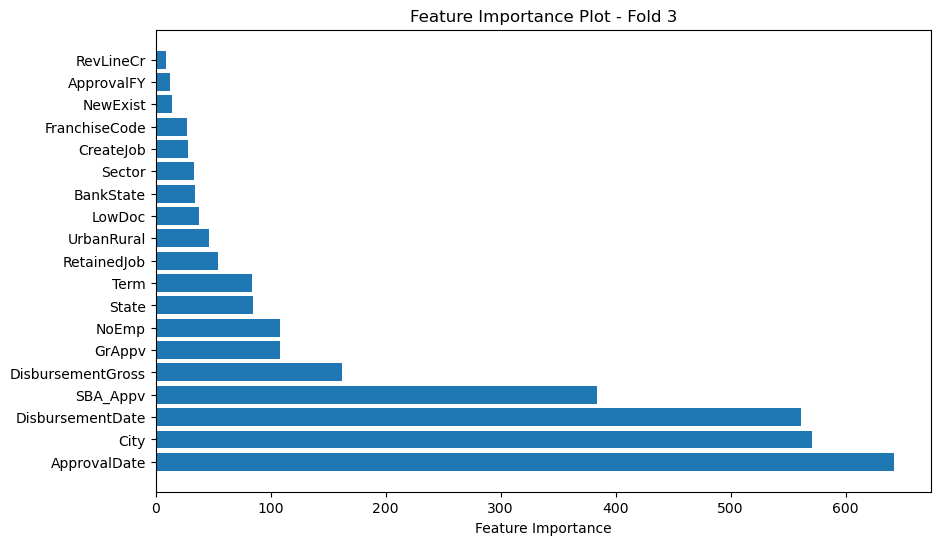

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 30214, number of negative: 3632
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8251
[LightGBM] [Info] Number of data points in the train set: 33846, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892690 -> initscore=2.118522
[LightGBM] [Info] Start training from score 2.118522
Fold 4 - s1-score: 0.9464


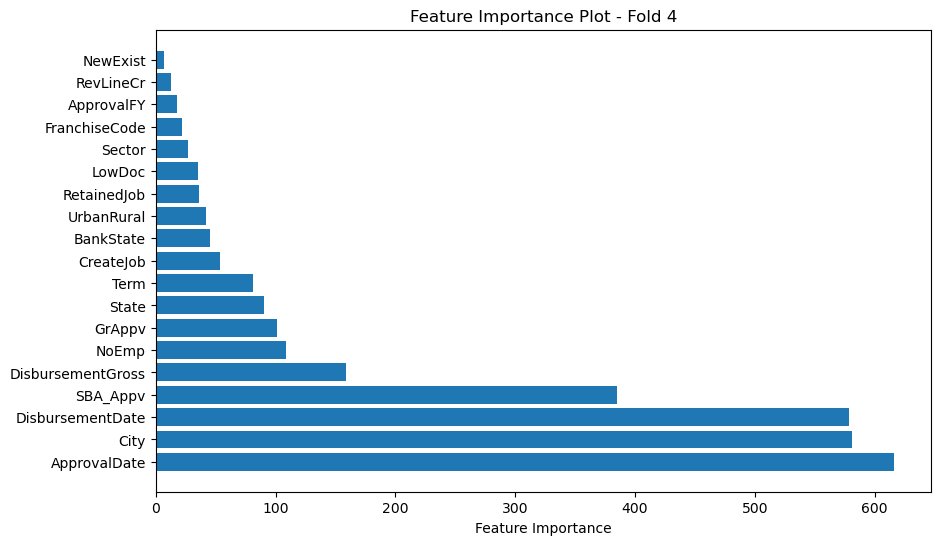

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 30214, number of negative: 3632
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8302
[LightGBM] [Info] Number of data points in the train set: 33846, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892690 -> initscore=2.118522
[LightGBM] [Info] Start training from score 2.118522
Fold 5 - s1-score: 0.9453


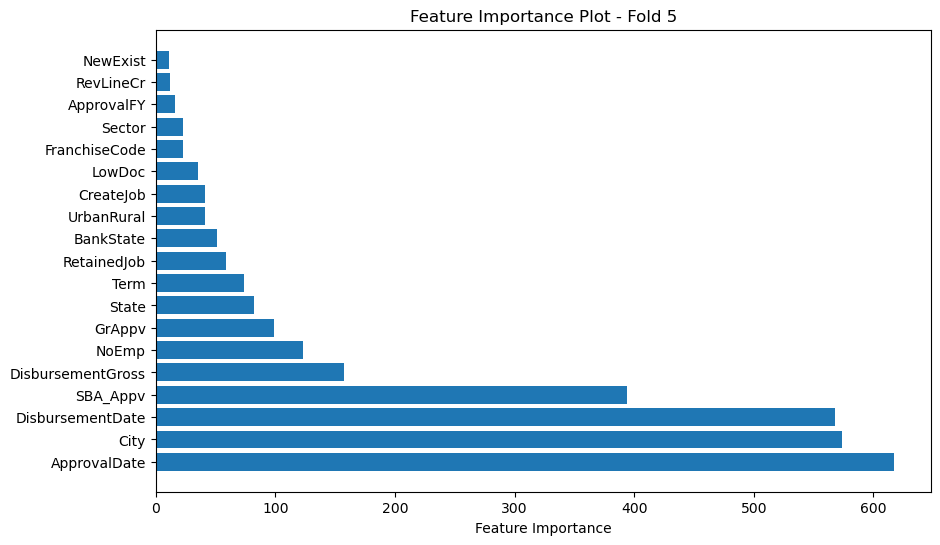

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 37767, number of negative: 4540
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9226
[LightGBM] [Info] Number of data points in the train set: 42307, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892689 -> initscore=2.118509
[LightGBM] [Info] Start training from score 2.118509


<Figure size 640x480 with 0 Axes>

In [66]:
%run baseline.py